In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flodatadenntimsiz/flo_data_20k.csv


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 80)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore')

In [10]:
#Adım 1: flo_data_20K.csv verisini okutunuz.

df = pd.read_csv("/kaggle/input/flodatadenntimsiz/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


In [11]:
#Adım 2: Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz.

df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
# Müşterinin e-ticaret sitesi/mağaza ile ilk kontağından bu yana geçen zaman olarak geçer.
# Bugünden minimum kontak tarihi çıkartılmasıyla bulunabilir.

df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days
# Müşterinin ne kadardır websitesinden/mağazadan hizmet aldığı, ne zamandır bize üye olduğu gibi bilgileri verir.
# Hesaplanması genellikle, bugünden son üyelik tarihi/son sipariş tarihinin çıkartılmasıyla elde edilir.

df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
# Müşterinin ne sıklıkla alışveriş yaptığını, ne sıklıkla siteye giriş yaptığını gösteren metriktir.
# Genellikle sipariş numarası/sipariş kodunun saydırılmasıyla sonuç verir.

df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']
# Müşterinin harcamalarının toplamıdır. E-ticaret sitesine getirdiği ciro,
# aldığı hizmetler sonrası toplanan getiri olarak da tanımlanır.

In [18]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=4, car_th=20)

Observations: 19945
Variables: 16
cat_cols: 2
num_cols: 8
cat_but_car: 6
num_but_cat: 0


In [19]:
#Kategorik Kolonlarımız tanıyalım ve müşteri sınıflamasına etki ettiği için encode edelim

cat_cols
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=False)
    
def one_hot_encoder(df, categorical_cols, drop_first=False):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

df = one_hot_encoder(df, cat_cols, drop_first=True)

             order_channel  Ratio
Android App           9495 47.606
Mobile                4882 24.477
Ios App               2833 14.204
Desktop               2735 13.713
##########################################
             last_order_channel  Ratio
Android App                6783 34.009
Offline                    6608 33.131
Mobile                     3172 15.904
Ios App                    1696  8.503
Desktop                    1686  8.453
##########################################


#  K-Means ile Müşteri Segmentasyonu

In [20]:
#Adım 1: Değişkenleri standartlaştırınız.
sc = MinMaxScaler((0, 1))
df_new = sc.fit_transform(df[num_cols])
df_new = pd.DataFrame(df_new, columns=num_cols)
df_new = df_new.merge(df.iloc[:, -7:], left_index=True, right_index=True)

In [21]:
#Adım 2: Optimum küme sayısını belirleyiniz.

kmeans = KMeans()
ssd = []
K = range(1, 40)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_new)
    ssd.append(kmeans.inertia_) #her bir "k" değeri için ssd değeridir.

In [22]:
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 39,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [23]:
kmeans.cluster_centers_

array([[ 6.31151925e-03,  1.50207734e-02,  2.13727721e-02,
         8.01839692e-03,  1.65466292e-01,  1.49565925e-01,
         1.43911793e-02,  1.58643570e-02,  9.71445147e-16,
        -4.44089210e-16, -4.99600361e-16, -1.11022302e-16,
         4.71844785e-16,  3.88578059e-16,  1.00000000e+00],
       [ 5.08955032e-02,  7.59734093e-03,  1.14511703e-02,
         3.47123650e-02,  6.29141802e-01,  2.52982086e-01,
         5.47435897e-02,  3.82604230e-02,  0.00000000e+00,
         2.22044605e-16, -1.38777878e-16, -1.11022302e-16,
        -2.77555756e-17,  3.33066907e-16, -8.32667268e-16],
       [ 3.58282284e-03,  5.82225227e-03,  1.04006488e-02,
         5.67859754e-03,  1.96417272e-01,  4.24835366e-01,
         6.70892495e-03,  9.22522574e-03,  8.88178420e-16,
        -4.16333634e-16,  1.00000000e+00, -5.55111512e-17,
         4.57966998e-16,  1.00000000e+00, -1.38777878e-15],
       [ 1.15286475e-02,  8.42108020e-03,  1.36708963e-02,
         1.33900198e-02,  1.90122159e-01,  1.03745326

In [24]:
kmeans.labels_

array([ 0,  9, 10, ...,  3, 32, 20], dtype=int32)

In [25]:
kmeans.inertia_

518.1948242609532

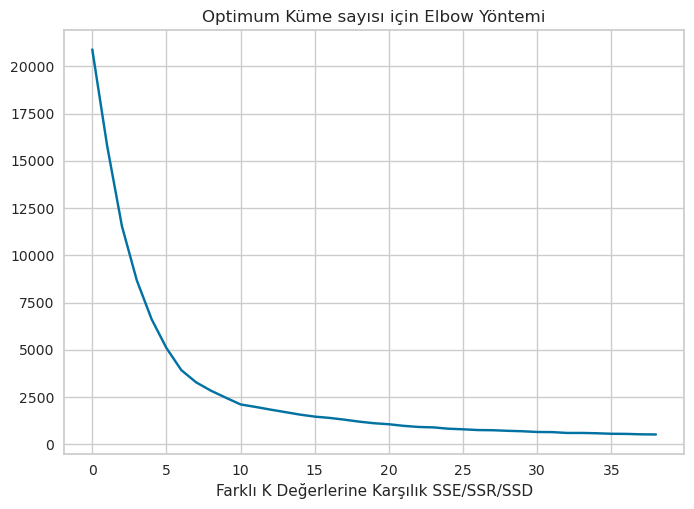

In [26]:
plt.plot(ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show(block=True)

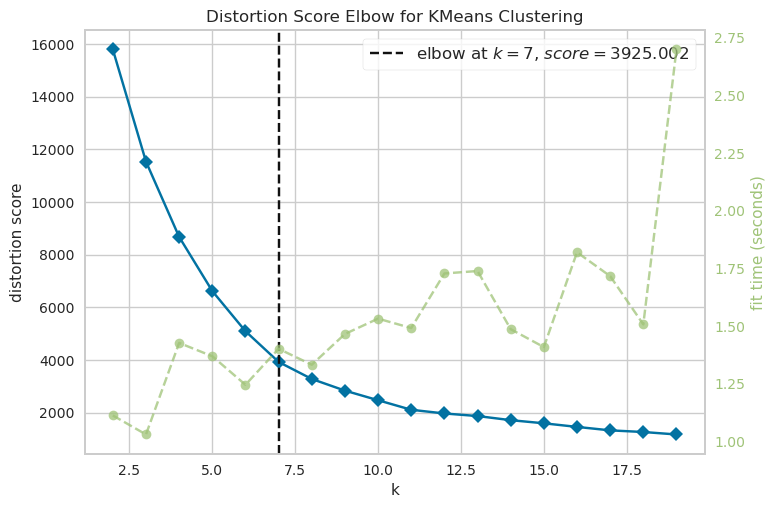

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_new)
elbow.show(block=True)

In [28]:
# Optimum küme sayısı
elbow.elbow_value_

7

In [31]:
#Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz
#Kmeans fonsiyonuna Elbow sayımızı ekleyerek ilgili kümelerimizi oluşturalım

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_new)

# Etiketlerin değişken atamasını yapıyoruz.
clusters = kmeans.labels_

# Mevcut DF içerisine küme sayılarını ekliyoruz.
df["cluster"] = clusters
df["cluster"] = df["cluster"] + 1

In [32]:
# Kümelere göre dağılımını kontrol edelim
def Ratio_(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        
Ratio_(df, "cluster")

   cluster  Ratio
2     6649 33.337
6     3202 16.054
5     3172 15.904
1     1871  9.381
4     1830  9.175
7     1686  8.453
3     1535  7.696
##########################################


In [33]:
# Adım 4: Herbir segmenti istatistiksel olarak inceleyeniz.

df.groupby("cluster").agg(["mean", "median", "count", "sum"]).T

cluster                                            1            2           3           4           5           6           7
order_num_total_ever_online       mean         2.134        3.694       1.745       3.628       2.842       2.648       3.963
                                  median       1.000        2.000       1.000       2.000       2.000       2.000       2.000
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum       3993.000    24560.000    2679.000    6640.000    9015.000    8478.000    6681.000
order_num_total_ever_offline      mean         2.272        1.736       2.174       1.732       1.633       2.469       1.652
                                  median       2.000        1.000       2.000       1.000       1.000       2.000       1.000
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum       4251.000    11545.000    3337.000    3170.000    5180.000    7905.000    2785.000
customer_value_total_ever_offline mean       306.587      215.658     312.531     226.053     205.306     358.311     216.489
                                  median     230.950      149.990     240.460     159.990     146.480     250.595     150.475
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum     573623.740  1433908.060  479735.090  413677.340  651229.190 1147311.760  365001.020
customer_value_total_ever_online  mean       276.529      602.351     222.669     645.144     437.422     429.676     658.913
                                  median     183.730      365.950     149.990     408.840     272.225     251.985     359.540
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum     517386.420  4005030.900  341796.930 1180614.010 1387502.350 1375823.870 1110926.630
tenure                            mean      1751.445     1523.468    2180.843    1535.273    1549.552    1506.013    1670.473
                                  median    1613.000     1444.000    2090.000    1445.000    1442.000    1393.000    1481.000
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum    3276954.000 10129542.000 3347594.000 2809550.000 4915179.000 4822253.000 2816418.000
recency                           mean       968.764      931.402     981.949     944.826     929.986     951.571     936.334
                                  median     940.000      910.000     961.000     923.000     914.000     922.000     914.000
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum    1812558.000  6192891.000 1507291.000 1729032.000 2949916.000 3046930.000 1578659.000
frequency                         mean         4.406        5.430       3.919       5.361       4.475       5.116       5.614
                                  median       4.000        4.000       3.000       4.000       3.000       4.000       4.000
                                  count     1871.000     6649.000    1535.000    1830.000    3172.000    3202.000    1686.000
                                  sum       8244.000    36105.000    6016.000    9810.000   14195.000   16383.000    9466.000
monetary                          mean       583.116      818.009     535.200     871.197     642.727     787.987     875.402
                                  median     479.700      592.780     434.170     633.405     473.385     587.935     575.125
                                  count     1871.000     6649.000    1535.000    1830.000    3

# Hierarchical Clustering ile Müşteri Segmentasyonu

In [34]:
# Adım 1: Görev 2'de standırlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.

hc_ward = linkage(df_new, "ward")

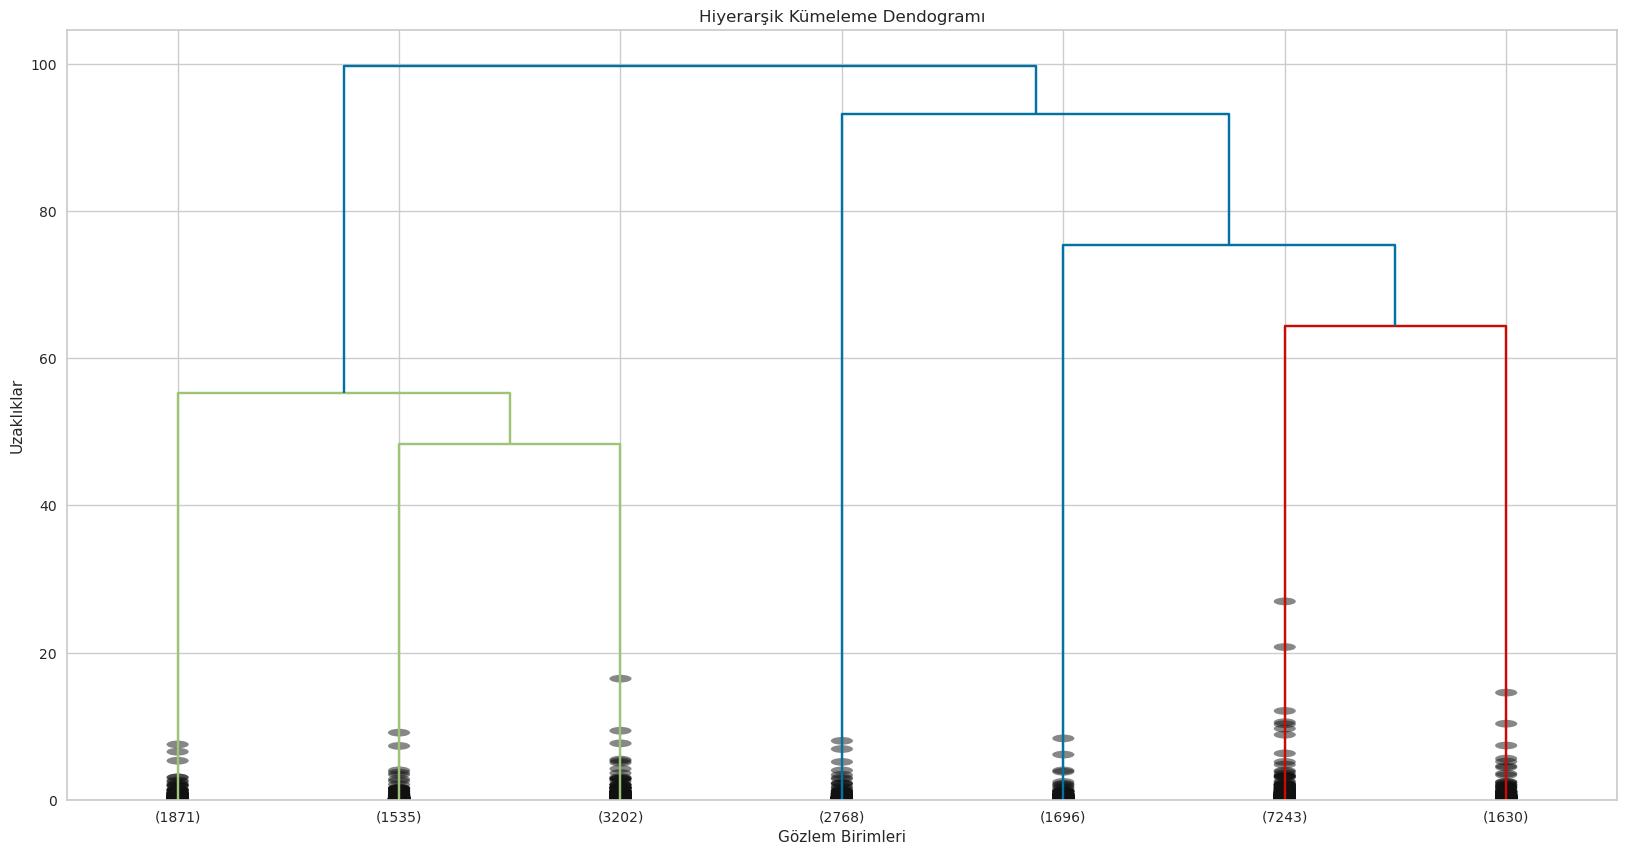

In [35]:
plt.figure(figsize=(20, 10))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_ward,
            truncate_mode="lastp",
            p=7,
            show_contracted=True,
            leaf_font_size=10)
plt.show(block=True)

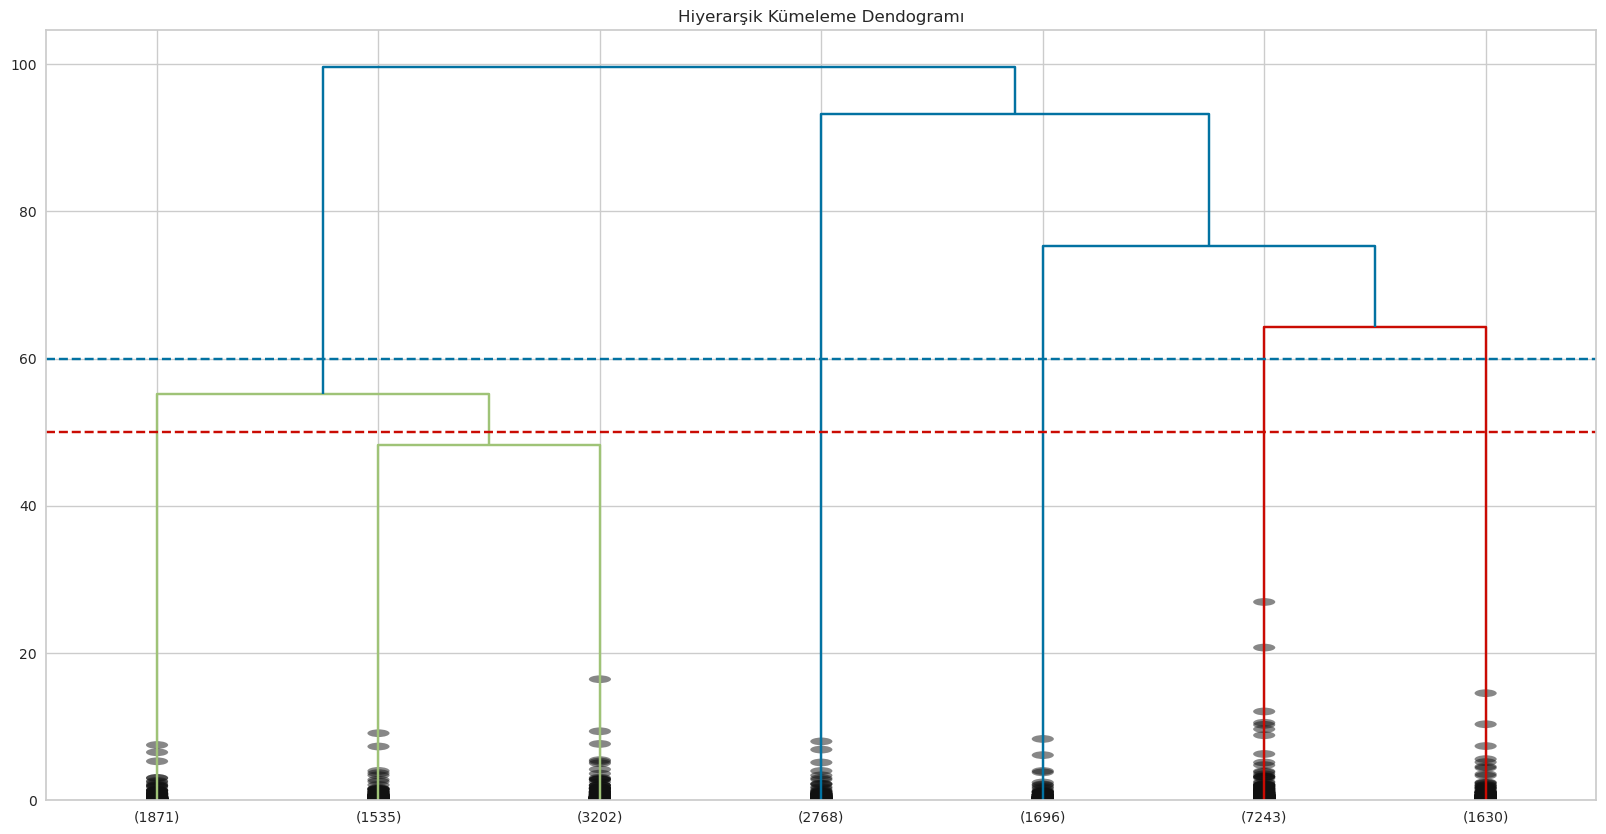

In [36]:
plt.figure(figsize=(20, 10)) #grafiğin boyutunu belirler
plt.title("Hiyerarşik Kümeleme Dendogramı")
dend = dendrogram(hc_ward,
                 truncate_mode="lastp",
                  p=7,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=60, color="b", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
plt.show(block=True)

In [37]:
# Adım 2: Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.

h_cluster = AgglomerativeClustering(n_clusters=6, linkage="ward")
h_clusters = h_cluster.fit_predict(df_new)
df["h_cluster"] = h_clusters
df["h_cluster"] = df["h_cluster"] + 1
df.head()

,master_id,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline,cluster,h_cluster
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],1023,904,5.000,939.370,0,0,0,0,0,0,1,6,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2383,914,21.000,2013.550,0,0,0,0,0,1,0,5,5
2,69b69676-1a40-11ea-941b-000d3a38a36f,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",1361,995,5.000,585.320,0,0,0,0,0,0,0,2,5
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",955,944,2.000,121.970,0,0,0,0,0,0,0,2,5
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],1477,895,2.000,209.980,1,0,0,1,0,0,0,7,2


In [38]:
# Kümelere göre dağılımını kontrol edelim
def Ratio_(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        
Ratio_(df, "h_cluster")

   h_cluster  Ratio
5       7243 36.315
1       4737 23.750
3       2768 13.878
6       1871  9.381
4       1696  8.503
2       1630  8.172
##########################################


# Adım 3: Her bir segmenti istatistiksel olarak inceleyeniz.

In [39]:
df.groupby("h_cluster").agg(["mean", "median", "count", "sum"]).T

h_cluster                                          1           2           3           4            5           6
order_num_total_ever_online       mean         2.355       3.748       2.410       3.344        3.927       2.134
                                  median       1.000       2.000       1.000       2.000        2.000       1.000
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum      11157.000    6109.000    6671.000    5671.000    28445.000    3993.000
order_num_total_ever_offline      mean         2.373       1.647       1.630       1.724        1.734       2.272
                                  median       2.000       1.000       1.000       1.000        1.000       2.000
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum      11242.000    2685.000    4512.000    2924.000    12559.000    4251.000
customer_value_total_ever_offline mean       343.476     215.548     207.255     227.044      214.514     306.587
                                  median     249.950     149.990     149.980     159.990      149.990     230.950
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum    1627046.850  351343.400  573680.890  385067.130  1553724.190  573623.740
customer_value_total_ever_online  mean       362.597     609.416     375.566     607.343      638.010     276.529
                                  median     209.990     348.110     235.965     390.565      390.450     183.730
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum    1717620.800  993348.760 1039567.540 1030054.290  4621103.300  517386.420
tenure                            mean      1724.688    1667.818    1524.096    1519.587     1540.277    1751.445
                                  median    1500.000    1478.000    1436.000    1438.000     1449.000    1613.000
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum    8169847.000 2718543.000 4218699.000 2577220.000 11156227.000 3276954.000
recency                           mean       961.415     936.913     931.667     947.446      930.223     968.764
                                  median     933.000     914.500     917.000     930.000      909.000     940.000
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum    4554221.000 1527169.000 2578853.000 1606869.000  6737607.000 1812558.000
frequency                         mean         4.729       5.395       4.040       5.068        5.661       4.406
                                  median       4.000       4.000       3.000       4.000        4.000       4.000
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum      22399.000    8794.000   11183.000    8595.000    41004.000    8244.000
monetary                          mean       706.073     824.965     582.821     834.388      852.523     583.116
                                  median     531.150     563.940     439.370     603.120      615.690     479.700
                                  count     4737.000    1630.000    2768.000    1696.000     7243.000    1871.000
                                  sum    3344667.650 1344692.160 1613248.430 1415121.420  6174827.490 1091010.160
order_channel_Desktop             mean         0.324       0.736       0.000       0.000        0.000       0.000
                                  median       0.000       1.000       0.000       0.000        0.000       0.000
          